In [339]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import dill as pickle
import xgboost as xgb
from itertools import cycle

from sklearn.preprocessing import OneHotEncoder,LabelEncoder,FunctionTransformer,LabelBinarizer
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import confusion_matrix, RocCurveDisplay

# Data Collection / Data Cleaning

The data is collected from https://www.nflfastr.com/, only the last 3 years of data is taken as nfl teams change very frequently and using very old data would make the model less accurate for current day conditions.

In [61]:
#Read In data
df_2020 = pd.read_csv('../data/play_by_play_2020.csv',low_memory=False)
df_2021 = pd.read_csv('../data/play_by_play_2021.csv',low_memory=False)
df_2022 = pd.read_csv('../data/play_by_play_2022.csv',low_memory=False)

In [62]:
#Combine the dataframes into one
df = pd.concat([df_2020,df_2021,df_2022],axis = 0)

In [63]:
#Feature Selection
features = ['posteam','posteam_type','defteam','yardline_100','qtr','quarter_seconds_remaining','down','ydstogo','shotgun','posteam_score','defteam_score','score_differential','play_type']

In [64]:
#Have the Dataframe only have the columns of selected features
df = df[features]

In [65]:
#Check
df.head()

,posteam,posteam_type,defteam,yardline_100,qtr,quarter_seconds_remaining,down,ydstogo,shotgun,posteam_score,defteam_score,score_differential,play_type
0,NaN,NaN,NaN,NaN,1,900.0,NaN,0,0,NaN,NaN,NaN,NaN
1,SF,home,ARI,35.0,1,900.0,NaN,0,0,0.0,0.0,0.0,kickoff
2,SF,home,ARI,75.0,1,900.0,1.0,10,1,0.0,0.0,0.0,pass
3,SF,home,ARI,55.0,1,882.0,1.0,10,1,0.0,0.0,0.0,run
4,SF,home,ARI,41.0,1,839.0,1.0,10,0,0.0,0.0,0.0,run


# Data Cleaning

In [66]:
df.isnull().sum()

posteam                      11136
posteam_type                 11136
defteam                      11136
yardline_100                 12689
qtr                              0
quarter_seconds_remaining        8
down                         25931
ydstogo                          0
shotgun                          0
posteam_score                11136
defteam_score                11136
score_differential           11136
play_type                     6580
dtype: int64

In [67]:
#Since play_type is going to be our target variable, lets look into it
df[df['play_type'].isna()]

,posteam,posteam_type,defteam,yardline_100,qtr,quarter_seconds_remaining,down,ydstogo,shotgun,posteam_score,defteam_score,score_differential,play_type
0,NaN,NaN,NaN,NaN,1,900.0,NaN,0,0,NaN,NaN,NaN,NaN
44,SF,home,ARI,NaN,1,0.0,NaN,0,0,10.0,7.0,3.0,NaN
76,NaN,NaN,NaN,NaN,2,120.0,NaN,0,0,NaN,NaN,NaN,NaN
92,NaN,NaN,NaN,NaN,2,0.0,NaN,0,0,NaN,NaN,NaN,NaN
134,ARI,away,SF,NaN,3,0.0,NaN,0,0,10.0,13.0,-3.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49900,NaN,NaN,NaN,NaN,2,0.0,NaN,0,0,NaN,NaN,NaN,NaN
49908,NaN,NaN,NaN,NaN,3,750.0,NaN,0,0,NaN,NaN,NaN,NaN
49939,SF,away,PHI,NaN,3,0.0,NaN,0,0,7.0,28.0,-21.0,NaN
49964,NaN,NaN,NaN,NaN,4,120.0,NaN,0,0,NaN,NaN,NaN,NaN


In [68]:
#It looks like the play_type is nan when its the end of a quarter, half time, 2 minute warning, or a timeout
#so it's safe to drop these rows
df.dropna(subset = 'play_type',inplace = True)

In [69]:
#Lets investigate more into our target variable
df['play_type'].value_counts()

pass           61520
run            43790
no_play        13533
kickoff         8630
punt            6470
extra_point     3961
field_goal      3192
qb_kneel        1296
qb_spike         223
Name: play_type, dtype: int64

There's a value in play type that indicates there was no play that happened, since we're trying to predict plays, we don't want this in our model.

In [70]:
#Drop where play_type is no_play
df = df[df['play_type'] != 'no_play']

In [71]:
#Check
df['play_type'].value_counts()

pass           61520
run            43790
kickoff         8630
punt            6470
extra_point     3961
field_goal      3192
qb_kneel        1296
qb_spike         223
Name: play_type, dtype: int64

In [72]:
#It looks like dropping play_type null values also dropped most of the nulls besides the down column
df.isnull().sum()

posteam                          0
posteam_type                     0
defteam                          0
yardline_100                     0
qtr                              0
quarter_seconds_remaining        0
down                         13014
ydstogo                          0
shotgun                          0
posteam_score                    0
defteam_score                    0
score_differential               0
play_type                        0
dtype: int64

In [73]:
#Check where down is null
df[df['down'].isna()]

,posteam,posteam_type,defteam,yardline_100,qtr,quarter_seconds_remaining,down,ydstogo,shotgun,posteam_score,defteam_score,score_differential,play_type
1,SF,home,ARI,35.0,1,900.0,NaN,0,0,0.0,0.0,0.0,kickoff
8,ARI,away,SF,35.0,1,710.0,NaN,0,0,0.0,3.0,-3.0,kickoff
16,SF,home,ARI,15.0,1,593.0,NaN,0,0,9.0,0.0,9.0,extra_point
17,ARI,away,SF,35.0,1,593.0,NaN,0,0,0.0,10.0,-10.0,kickoff
27,ARI,away,SF,15.0,1,415.0,NaN,0,0,6.0,10.0,-4.0,extra_point
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49897,SF,away,PHI,35.0,2,16.0,NaN,0,0,7.0,21.0,-14.0,kickoff
49901,SF,away,PHI,35.0,3,900.0,NaN,0,0,7.0,21.0,-14.0,kickoff
49935,PHI,home,SF,15.0,3,43.0,NaN,0,0,27.0,7.0,20.0,extra_point
49936,SF,away,PHI,35.0,3,43.0,NaN,0,0,7.0,28.0,-21.0,kickoff


The values in the down column that are null are due to the play being a kickoff or extra_point, since we dont want those play_types, we can drop the null value rows.

In [74]:
#Drop the null values 
df.dropna(subset = 'down',inplace = True)

In [75]:
df.isnull().sum()

posteam                      0
posteam_type                 0
defteam                      0
yardline_100                 0
qtr                          0
quarter_seconds_remaining    0
down                         0
ydstogo                      0
shotgun                      0
posteam_score                0
defteam_score                0
score_differential           0
play_type                    0
dtype: int64

# Exploratory Data Analysis

Since the play type is our target for the problem, let's look into more of how the data is distributed.

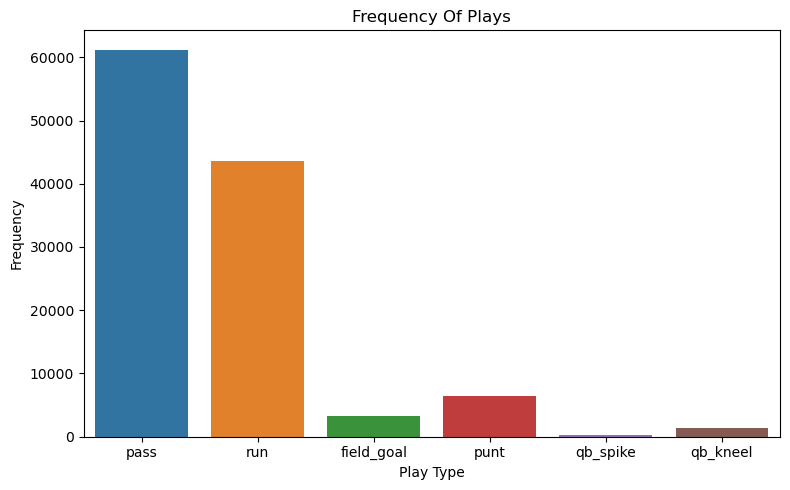

In [330]:
plt.figure(figsize=(8,5))
sns.countplot(data =df,x = 'play_type')
plt.xlabel('Play Type')
plt.ylabel('Frequency')
plt.title('Frequency Of Plays')
plt.tight_layout()
plt.savefig('../images/edavisuals/Plays.png');

/Users/jaysonv/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/jaysonv/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


''

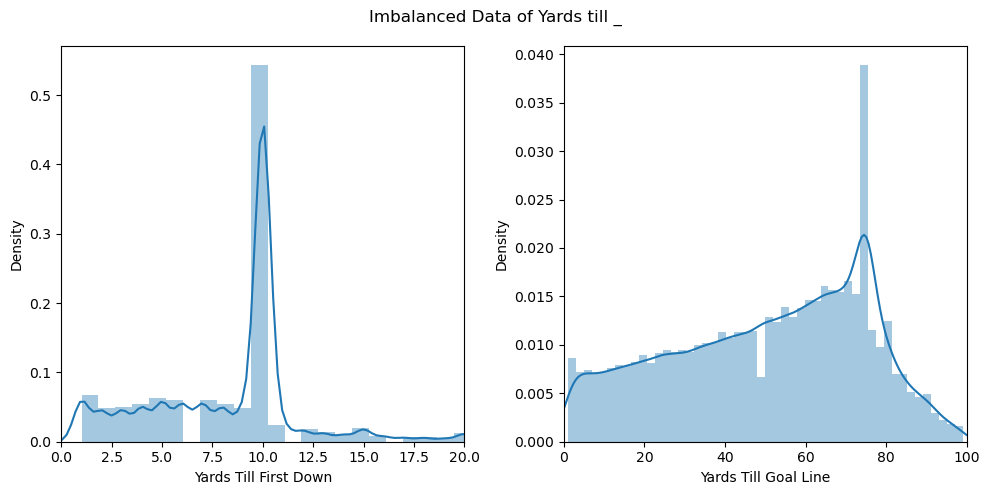

In [331]:
fig,axs = plt.subplots(nrows = 1, ncols = 2, figsize=(10,5))
plt.suptitle('Imbalanced Data of Yards till _')
sns.distplot(df['ydstogo'].values, ax = axs[0])
axs[0].set_xlim(0,20)
axs[0].set_xlabel('Yards Till First Down')
sns.distplot(df['yardline_100'].values, ax = axs[1])
axs[1].set_xlim(0,100)
axs[1].set_xlabel('Yards Till Goal Line')
plt.tight_layout()
plt.savefig('../images/edavisuals/ImbalancedDataYards.png')
;


As shown in the images above, we were are working with an imbalanced dataset. Our target variable has most of it's data under the pass or run class, and our features that have to do with yards, are not completely imbalanced, but have a skew to the left. 
In order to combat this we could implement sampling techniques to equalize the classes and features, but for now we'll leave it as it is and implement those techniques for a later project.

''

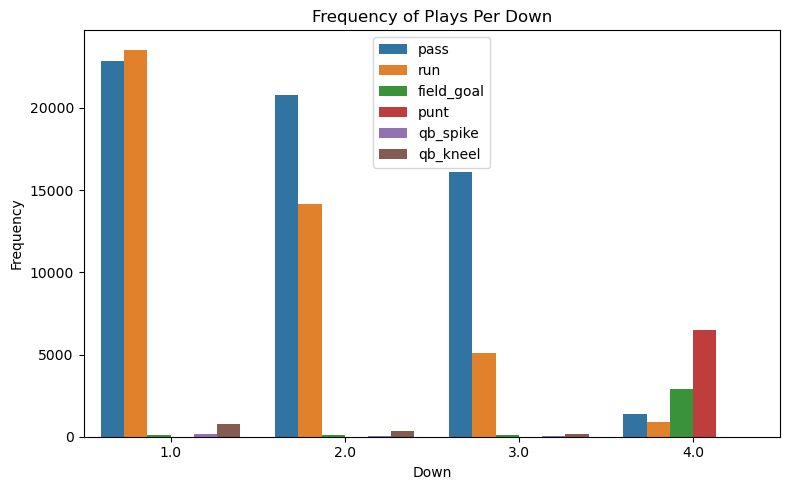

In [332]:
plt.figure(figsize=(8,5))
sns.countplot(data = df, x ='down',hue ='play_type')
plt.xlabel('Down')
plt.ylabel('Frequency')
plt.legend()
plt.title('Frequency of Plays Per Down')
plt.tight_layout()
plt.savefig('../images/edavisuals/PlaysPerDown.png')
;

''

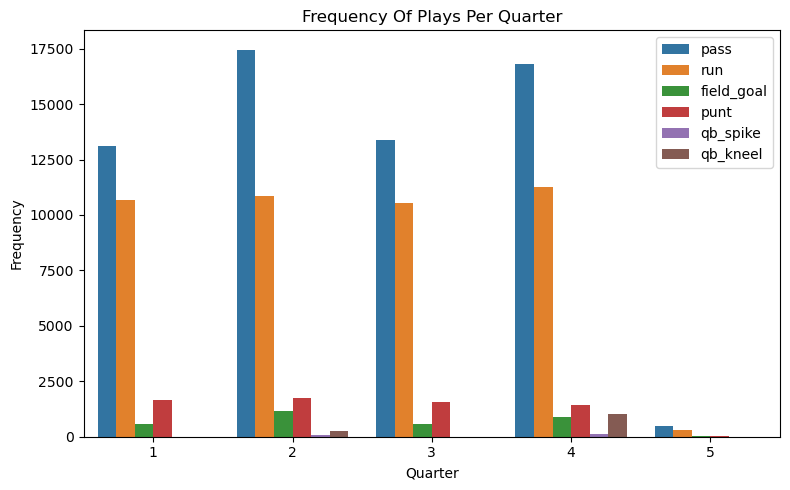

In [333]:
plt.figure(figsize=(8,5))
sns.countplot(data = df, x = 'qtr',hue = 'play_type')
plt.xlabel('Quarter')
plt.ylabel('Frequency')
plt.legend()
plt.title('Frequency Of Plays Per Quarter')
plt.tight_layout()
plt.savefig('../images/edavisuals/PlaysPerQuarter.png')
;

''

<Figure size 800x500 with 0 Axes>

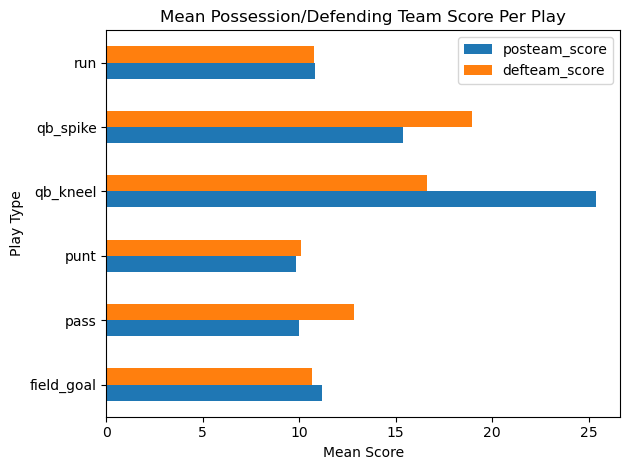

In [334]:
plt.figure(figsize=(8,5))
df.groupby('play_type').agg({'posteam_score':'mean','defteam_score':'mean'}).plot(kind='barh')
plt.xlabel('Mean Score')
plt.ylabel('Play Type')
plt.title('Mean Possession/Defending Team Score Per Play')
plt.tight_layout()
plt.savefig('../images/edavisuals/ScorePerPlay.png')
;

''

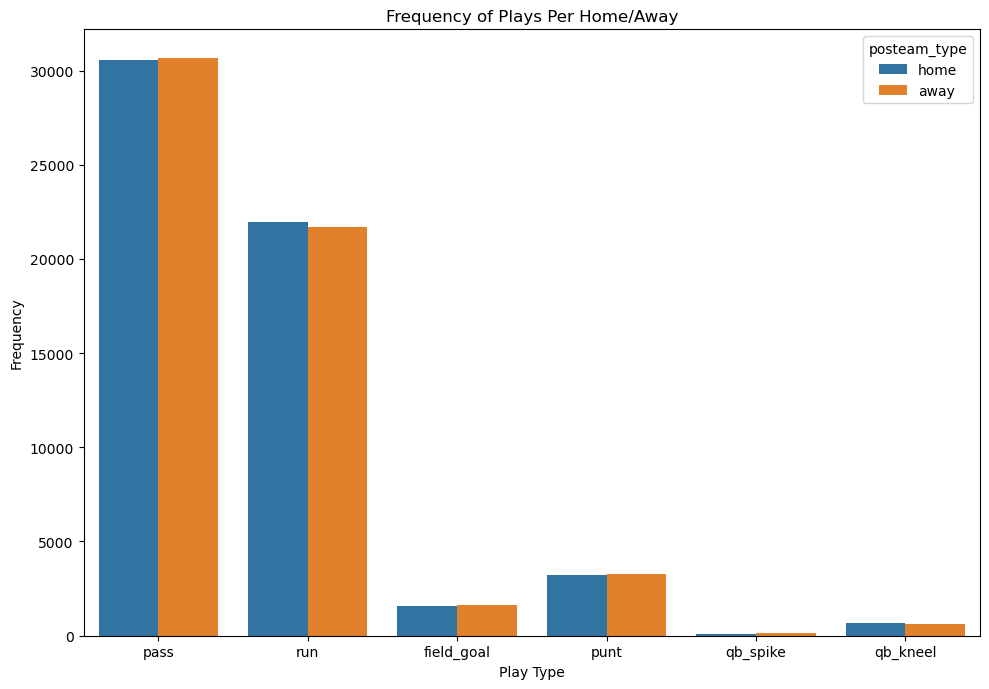

In [335]:
plt.figure(figsize = (10,7))
sns.countplot(data = df, x ='play_type', hue = 'posteam_type')
plt.xlabel('Play Type')
plt.ylabel('Frequency')
plt.title('Frequency of Plays Per Home/Away')
plt.tight_layout()
plt.savefig('../images/edavisuals/HomeAway.png')
;

''

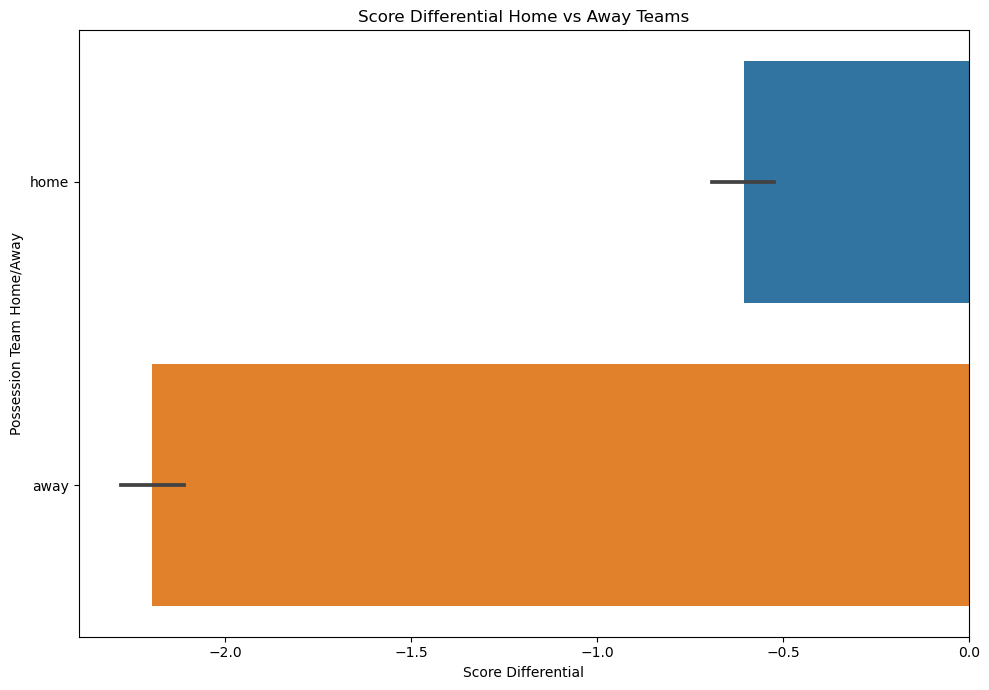

In [336]:
plt.figure(figsize = (10,7))
sns.barplot(data = df, y ='posteam_type',x='score_differential')
plt.xlabel('Score Differential')
plt.ylabel('Possession Team Home/Away')
plt.title('Score Differential Home vs Away Teams')
plt.tight_layout()
plt.savefig('../images/edavisuals/ScoreHomeAway.png')
;

# Modelling (XgBoost)
## Why Boosting?
When thinking of a model that can classify a robust dataset as accurately as possible, two methods come to mind, bagging and boosting. However in this case since we are working with an imbalanced dataset(a lot of the data is a pass or run play), it would make more sense to use a boosting model. Boosting methods are ideal for imbalanced datasets as the way it optimizes the loss function and adds weights to classes at each iteration.
## Why XgBoost?
Now that we chose to utilize a boosting algorithm, there are two different types of boosting that we have to consider, adaptive boosting and gradient boosting. In order to choose between the two, we have to understand the differences. Adaptive boosting and gradient boosting are both similar in the way they utilize weak learners to make a strong learner, however the difference between them is in how they add weights to classes. When a class is misclassified, adaptive boosting adds the weight to that class for the next iteration, vice versa for when a class is predicted correctly. However with gradient boosting, the model trains on the residuals of the preceeding iteration for the next iteration. Because of this gradient models tend to perform better than adaptive models but have a higher chance of overfitting and consumes more time. Since overfitting and time isn't an issue for this project, we will proceed with gradient boosting.



In [80]:
#Create X and y
X = df.drop(columns = ['play_type','score_differential','shotgun'])
y = df['play_type']

In [81]:
#Create Baseline
y.value_counts(normalize=True)

pass          0.527389
run           0.376279
punt          0.055743
field_goal    0.027501
qb_kneel      0.011166
qb_spike      0.001921
Name: play_type, dtype: float64

In [82]:
#Transform our y classes into numerical values
le = LabelEncoder()
y_sc = le.fit_transform(y)

In [83]:
#Show the classes that are being transformed in the label encoder
le.classes_

array(['field_goal', 'pass', 'punt', 'qb_kneel', 'qb_spike', 'run'],
      dtype=object)

In [84]:
#Train Test Split
X_train,X_test,y_train,y_test = train_test_split(X,y_sc,random_state = 42, stratify = y ,shuffle = True)

In [85]:
#Use ColumnTransformer to onehot encode categorical variables, used columntransformer incase use of standardscaler is necessary
processor = ColumnTransformer([
    ('ohe',OneHotEncoder(),['posteam','posteam_type','defteam'])
],remainder= 'passthrough')

In [86]:
#https://stackoverflow.com/questions/28384680/scikit-learns-pipeline-a-sparse-matrix-was-passed-but-dense-data-is-required

pipe_xgb = Pipeline([
    ('preprocess', processor),
    ('dense', FunctionTransformer(lambda x: x.todense(),accept_sparse=True)), #PCA requires todense because it comes as a sparse matrix
    ('pca', PCA()), #Principal Component Analysis
    ('xgb', xgb.XGBClassifier())
])
pipe_params = {
    'xgb__learning_rate': [0.1,0.3,1.0],
    'xgb__max_depth':[1,3,7],
    'xgb__base_score':[0.7,1.0],
    'xgb__n_estimators':[100,300]
}

In [87]:
#GridSearch over the pipeline
gs_xgb = GridSearchCV(
    pipe_xgb,
    param_grid = pipe_params,
    cv = 3
)

In [88]:
#fit the gridsearch
gs_xgb.fit(X_train,y_train)

/Users/jaysonv/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/Users/jaysonv/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/Users/jaysonv/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warning

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         OneHotEncoder(),
                                                                         ['posteam',
                                                                          'posteam_type',
                                                                          'defteam'])])),
                                       ('dense',
                                        FunctionTransformer(accept_sparse=True,
                                                            func=<function <lambda> at 0x7fcdc7b401f0>)),
                                       ('pca', PCA()),
                                       ('xgb',
                                        XGBClassifier(base_score=None,
 

In [89]:
#Train Score
gs_xgb.score(X_train,y_train)

/Users/jaysonv/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


0.7581992165512171

In [90]:
#Test Score
gs_xgb.score(X_test,y_test)

/Users/jaysonv/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


0.7013474859565082

# Model Evaluation
### Confusion Matrix

In [93]:
#Create preds to put into a confusion matrix
preds_test = gs_xgb.predict(X_test)

/Users/jaysonv/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


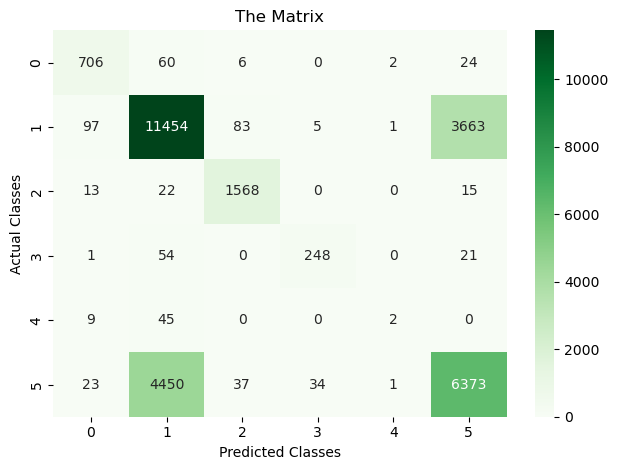

In [341]:
cm = confusion_matrix(y_test,preds_test)
sns.heatmap(cm,cmap = 'Greens',annot = True,fmt = 'g')
plt.xlabel('Predicted Classes')
plt.ylabel('Actual Classes')
plt.title('The Matrix')
plt.tight_layout()
plt.savefig('../images/edavisuals/Matrix.png')

In [338]:
#Display what the classes are to compare it with the confusion matrix
le.classes_

array(['field_goal', 'pass', 'punt', 'qb_kneel', 'qb_spike', 'run'],
      dtype=object)

### Roc Curve
Roc curves were meant to show the false and true positive rates of a binary classification model. However this doesn't mean we can't utilize a roc curve for a multiclass problem. We could compute the roc curve for each class by doing a one vs rest technique, where the class being looked at is positive and the rest of the classes are negative.  https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

In [146]:
preds_roc_proba = gs_xgb.predict_proba(X_test)

/Users/jaysonv/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


In [164]:
label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)

In [165]:
y_onehot_test.shape

(29017, 6)

In [170]:
le.classes_

array(['field_goal', 'pass', 'punt', 'qb_kneel', 'qb_spike', 'run'],
      dtype=object)

''

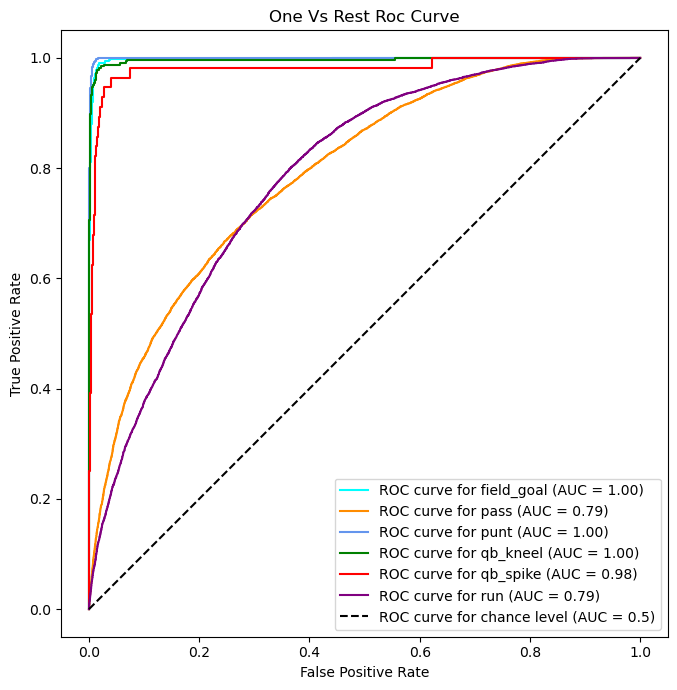

In [347]:
#Taken From Sklearns Documentation https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#multiclass-settings
fig,ax = plt.subplots(figsize = (10,7))
# Plot of a ROC curve for a specific class
colors = cycle(["aqua", "darkorange", "cornflowerblue",'green','red','purple'])
for class_id, color in zip(range(6), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        preds_roc_proba[:, class_id],
        name=f"ROC curve for {le.classes_[class_id]}",
        color=color,
        ax=ax
    )
plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One Vs Rest Roc Curve")
plt.legend()
plt.tight_layout()
plt.savefig('../images/edavisuals/OnevsRest.png')
;

# Testing

In [126]:
new_row = {'posteam':'KC','posteam_type':'home','defteam':'PIT','yardline_100':70,'qtr':4 ,'quarter_seconds_remaining':600.0,'down':4,'ydstogo':10,'posteam_score':28,'defteam_score':14}

In [127]:
tests = pd.DataFrame(new_row,index = df.index)

In [128]:
tests = tests.head(1)

In [129]:
preds = gs_xgb.predict(tests)

/Users/jaysonv/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


In [130]:
preds_proba = gs_xgb.predict_proba(tests)

/Users/jaysonv/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


In [131]:
preds_proba[0]

array([1.0373650e-04, 7.2639119e-03, 9.8975688e-01, 9.8318451e-05,
       9.8798002e-05, 2.6783939e-03], dtype=float32)

In [132]:
predicted_class = le.classes_[preds[0]]
predicted_class_proba = round(preds_proba[0][preds[0]] * 100,2)

In [133]:
le.classes_

array(['field_goal', 'pass', 'punt', 'qb_kneel', 'qb_spike', 'run'],
      dtype=object)

In [134]:
print(f'Theres a {predicted_class_proba}% chance this play will be a {predicted_class}.')

Theres a 98.98% chance this play will be a punt.


# Pickling

In order to use the model in our streamlit app, we will pickle the model and the dataframe. We import dill as pickle as the the dill library is the same as pickle but it allows a functiontransformer to be pickled.

In [ ]:
df.to_pickle('../models/df.pkl')

In [137]:
with open('../models/gs_xgb.pkl','wb') as f:
    pickle.dump(gs_xgb,f)